In [1]:
import os
from pathlib import Path

import jax
import jax.numpy as jnp
from jax import random

import jax_md_mod
from jax_md import space, simulate, partition
from jax_md_mod import custom_quantity
from jax_md_mod.model import prior

import numpy as onp

from matplotlib import pyplot as plt

from chemtrain import ensemble, quantity

base_path = Path(os.environ.get("DATA_PATH", "./data"))

# Prior Simulation

The potential $U(\mathbf r)$ describes all interactions between particles of
a system.
However, not all these interactions are simple to parametrize [^Das2009].
For example, short range interactions are crucial to ensure that particles do
not overlap, but require quickly increasing forces at small particle distances.
Hence, a common approach separates the full potential in to a learnable bias
$\Delta U_\theta$ and a part kept fixed $U^\text{prior}$ during the variational
procedure

```{math}
U(\mathbf r) = U^\text{prior}(\mathbf r) + \Delta U_\theta(\mathbf r)
```

Since the fixed potential manifests beliefs before seeing any data, it is
a frequently used termed *prior potential* as in Bayesian statistics.
Likewise, $\Delta$*-learning* refers to only learning an additive
correction on top of the prior potential.

## Setup Force Field

As a prior, we want to use a classical force field.
Therefore, we define the potential parameters in a force field file of the following form:

In [2]:
ff_path = base_path / "ethane.toml"

with open(ff_path, "r") as f:
    print(f.read())
    
force_field = prior.ForceField.load_ff(ff_path)

# Parameters for ethane, converted from:
# Nikitin, A.M., Milchevskiy, Y.V. & Lyubartsev, A.P.
# A new AMBER-compatible force field parameter set for alkanes.
# J Mol Model 20, 2143 (2014). https://doi.org/10.1007/s00894-014-2143-6

[nonbonded]
# Mass repartitioning with HC + 3u
atomtypes = """
# name, species,    mass,    sigma,    epsilon
    HC,       0,   4.011, 1.24e-02,  6.255e-01 # kcal/mol = 4.184 kJ/mol
   CH3,       1,   6.035, 1.84e-01,  7.322e-01
"""

[bonded]
bondtypes = """
#    i,    j,     b0,    kb
  CH3,    HC, 0.1093,  14225.6 # kcal/mol/A^2 = 41.84 kJ/mol/nm^2
  CH3,   CH3, 0.1526,  10041.6

"""

angletypes = """
#    i,    j,    k,    th0,    kth
    HC,  CH3,    HC, 107.0,  0.042 # kcal/mol/rad^2 = 1.28e-4 kJ/mol/deg^2
    HC,  CH3,   CH3, 110.7,  0.066

"""

dihedraltypes = """
#    i,    j,    k,    l,    phase,    kd,    pn
    HC,  CH3,   CH3,  HC,      0.0, 6.067,     3 # kcal/mol = 4.184 kJ/mol

"""



## Setup Topology

We defined the energies associated with each bond, angle, and dihedral.
However, to compute the energy for a given set of coordinates, we must define
which atoms form these bonds, angles, and dihedral angles.

The bonds are already part of the PDB file we generated via open-babel.
Therefore, we can traverse the graph and extract all atoms
connected by simple paths of length 2 and 3.
Therefore, we find the angles and dihedral angles.

In [3]:
import mdtraj

conf_path = base_path / "ethane.pdb"

unv = mdtraj.load(conf_path, standard_names=False)
top = unv.top

topology = prior.Topology.from_mdtraj(top, mapping=force_field.mapping(by_name=True))

/Users/paul/Lokal/chemtrain/jax_md_mod/model/prior.py:526: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  improper_dihedral_idx = jnp.zeros((0, 4), dtype=jnp.int_)


We can also plot the initial conformation.

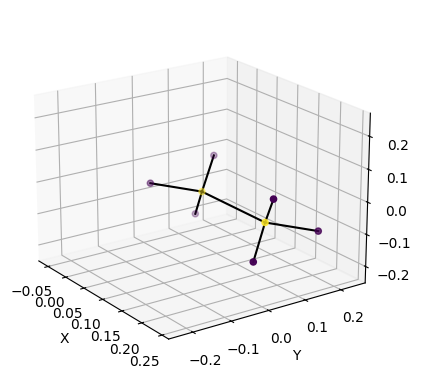

In [4]:
box = jnp.asarray([1.0, 1.0, 1.0])
r_init = unv.xyz[0]

ax = plt.figure().add_subplot(projection='3d')

# Plot the atoms and assign the correct color to the species
ax.scatter(r_init[:, 0], r_init[:, 1], r_init[:, 2], c=topology.get_atom_species())

for idx1, idx2 in topology.get_bonds()[0]:
    ax.plot(r_init[(idx1, idx2), 0], r_init[(idx1, idx2), 1], r_init[(idx1, idx2), 2], color="k")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

centers = r_init.mean(axis=0)
rmin = centers - 0.25
rmax = centers + 0.25

ax.set_xlim3d([rmin[0], rmax[2]])
ax.set_ylim3d([rmin[1], rmax[2]])
ax.set_zlim3d([rmin[2], rmax[2]])

ax.view_init(elev=20., azim=-35, roll=0)

## Setup Prior Energy

Now, we can combine the force field and topology into a function that generates
concrete energies for a given set of coordinates.

The force field does not act directly on the particle position.
Instead, it acts on the displacement between the particles, respecting the
periodic boundaries via the minimum image convention.
Thus, we first have to initialize this periodical space.

In [5]:
r_init = jnp.asarray(r_init)

displacement_fn, shift_fn = space.periodic_general(box, fractional_coordinates=False)
neighbor_fn = partition.neighbor_list(displacement_fn, box, 1.0)

nbrs_init = neighbor_fn.allocate(r_init)

prior_energy_fn = prior.init_prior_potential(displacement_fn, nonbonded_type="lennard_jones")(topology, force_field)

print(f"Energy on initial configuration: {prior_energy_fn(r_init, nbrs_init)}")

/Users/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


Energy on initial configuration: 0.25371792912483215


/Users/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


## Setup Simulation

To stabilize the simulation, we re-partition the masses from the carbon atoms
to the hydrogen atoms.

In [6]:
timings = ensemble.sampling.process_printouts(
    time_step=0.001, total_time=1e3, t_equilib=1e2,
    print_every=0.1, t_start=0.0
)

init_ref_state, sim_template = ensemble.sampling.initialize_simulator_template(
    simulate.nvt_langevin, shift_fn=shift_fn, nbrs=nbrs_init,
    init_with_PRNGKey=True, extra_simulator_kwargs={"kT": 2.56, "gamma": 1.0, "dt": 0.001}
)

mass = force_field.get_nonbonded_params(topology.get_atom_species())[0][:, 0]

reference_state = init_ref_state(
    random.PRNGKey(11), r_init,
    energy_or_force_fn=prior_energy_fn,
    init_sim_kwargs={"mass": mass, "neighbor": nbrs_init}
)

## Simulate

With the space, force function, and simulator set up, we can now compute a trajectory.
Following, we evaluate the potential energy, forces, and root mean
square distance (rmsd) for this trajectory for every sampled conformation.

In [7]:
quantities = {
    "energy": lambda state, *args, **kwargs: prior_energy_fn(state.position, *args, **kwargs),
    "rmsd": custom_quantity.init_rmsd(r_init, displacement_fn, box),
    "force": lambda state, *args, **kwargs: -jax.grad(prior_energy_fn)(state.position, *args, **kwargs)
}

simulate_fn = ensemble.sampling.trajectory_generator_init(
    simulator_template=sim_template,
    energy_fn_template=lambda _: prior_energy_fn,
    ref_timings=timings,
    quantities=quantities,
)

traj_state = simulate_fn(None, reference_state)

Covariance has shape (3, 3)
Shapes are V: (3, 3), U: (3, 3)


/Users/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


## Results

We save the energies, forces, and positions for later use, e.g., in coarse-graining applications.

In [8]:
# We save the force, energy, and position computations for later
onp.save(base_path / "forces_ethane.npy", traj_state.aux["force"])
onp.save(base_path / "energies_ethane.npy", traj_state.aux["energy"])
onp.save(base_path / "positions_ethane.npy", traj_state.trajectory.position)

Text(0, 0.5, 'Frequency')

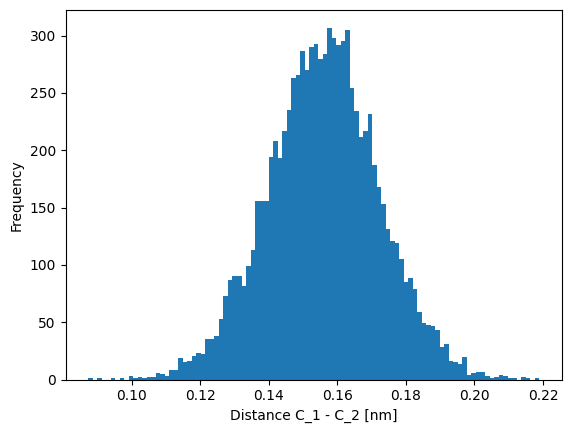

In [9]:
disp = jax.vmap(displacement_fn)(
    traj_state.trajectory.position[:, 0, :],
    traj_state.trajectory.position[:, 1, :]
)
dist_CC = jnp.sqrt(jnp.sum(jnp.square(disp), axis=-1))

plt.hist(dist_CC, bins=100)
plt.xlabel("Distance C_1 - C_2 [nm]")
plt.ylabel("Frequency")

Text(0, 0.5, 'Energy [kJ/mol]')

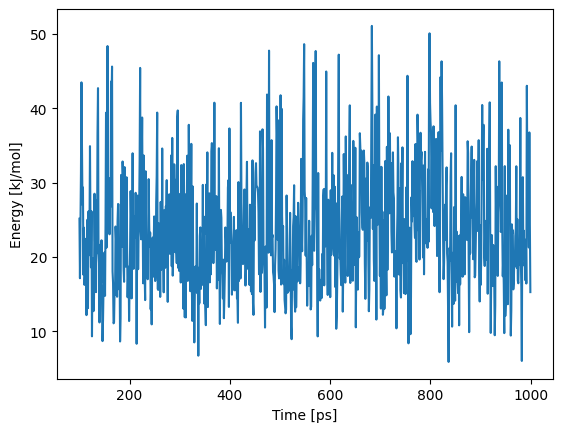

In [10]:
plt.plot(timings.t_production_end[::10], traj_state.aux["energy"][::10])
plt.xlabel("Time [ps]")
plt.ylabel("Energy [kJ/mol]")

Text(0, 0.5, 'RMSD [nm^2]')

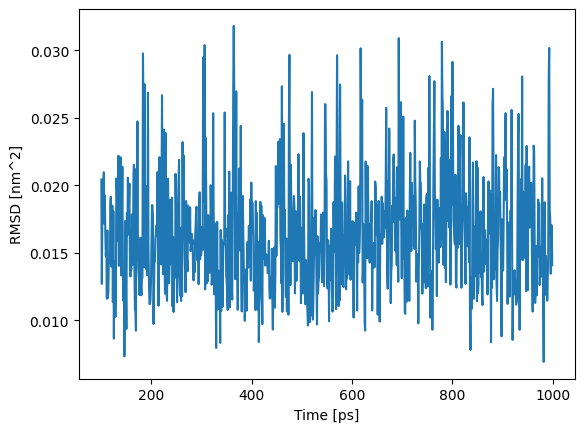

In [11]:
plt.plot(timings.t_production_end[::10], traj_state.aux["rmsd"][::10])
plt.xlabel("Time [ps]")
plt.ylabel("RMSD [nm^2]")

# References

[^Das2009]: Das, A.; Andersen, H. C. The Multiscale Coarse-Graining Method. III. A Test of Pairwise Additivity of the Coarse-Grained Potential and of New Basis Functions for the Variational Calculation. _The Journal of Chemical Physics_ **2009**, _131_ (3), 034102. [https://doi.org/10.1063/1.3173812](https://doi.org/10.1063/1.3173812).